In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf


tickers = ["MSFT", "AMZN", "NAT", "BAC", "DPZ", "DIS", "KO", "MCD", "COST", "SBUX"]

ohlc = yf.download(tickers, period="max", auto_adjust=True)
prices = ohlc["Close"].dropna(how="all")
prices.tail()


[*********************100%***********************]  10 of 10 completed


Ticker,AMZN,BAC,COST,DIS,DPZ,KO,MCD,MSFT,NAT,SBUX
Date,,,,,,,,,,
2025-05-12,208.639999,43.360001,1016.150024,110.489998,482.109985,69.529999,311.920013,448.436737,2.58,85.071114
2025-05-13,211.369995,44.279999,999.030029,111.379997,484.399994,68.959999,308.690002,448.316986,2.64,86.272652
2025-05-14,210.250000,44.740002,991.539978,112.940002,483.230011,69.160004,307.500000,452.109985,2.67,85.935036
2025-05-15,205.169998,44.380001,1010.469971,112.220001,485.910004,71.610001,314.480011,453.130005,2.72,86.650002
2025-05-16,205.589996,44.689999,1025.829956,113.419998,495.049988,72.000000,318.609985,454.269989,2.76,85.570000


In [3]:
market_prices = yf.download("SPY", period="max", auto_adjust=True)["Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Ticker,SPY
Date,
1993-01-29,24.452515
1993-02-01,24.626434
1993-02-02,24.678612
1993-02-03,24.939493
1993-02-04,25.043833


In [4]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'MSFT': 3376379854848,
 'AMZN': 2182625624064,
 'NAT': 584432768,
 'BAC': 336599711744,
 'DPZ': 16951254016,
 'DIS': 203900796928,
 'KO': 309907423232,
 'MCD': 227816669184,
 'COST': 455143325696,
 'SBUX': 97241751552}

In [5]:
import pypfopt
pypfopt.__version__
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

np.float64(3.3138823924933956)

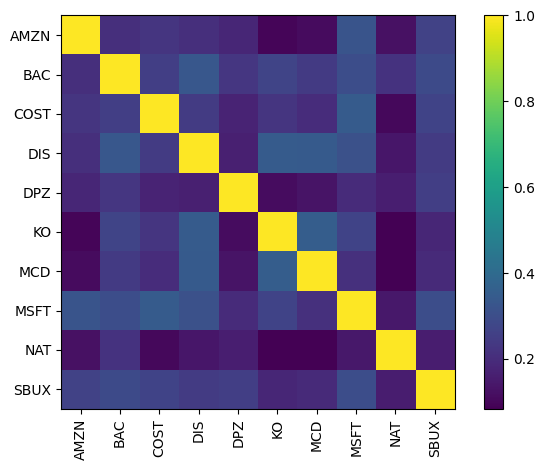

In [6]:
plotting.plot_covariance(S, plot_correlation=True);

In [7]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

Ticker
AMZN    0.200629
BAC     0.100786
COST    0.076814
DIS     0.090470
DPZ     0.037719
KO      0.051815
MCD     0.056674
MSFT    0.155008
NAT     0.040301
SBUX    0.076181
dtype: float64

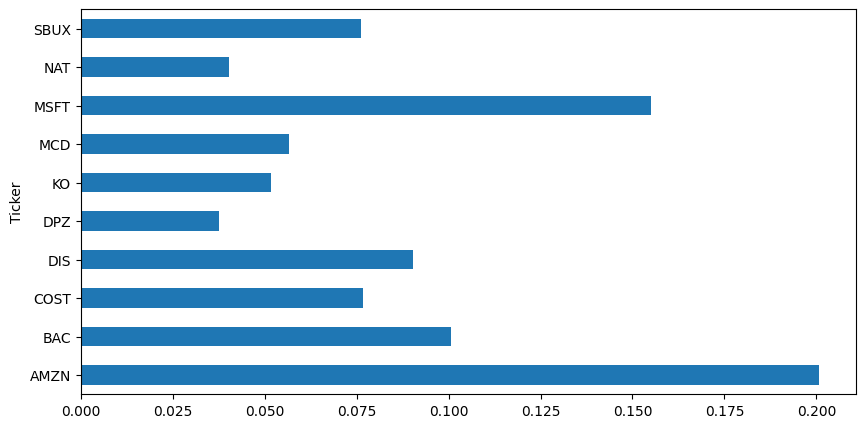

In [8]:
market_prior.plot.barh(figsize=(10,5));

In [9]:
# You don't have to provide views on all the assets
viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pypfopt/black_litterman.py:355: RuntimeWarning: divide by zero encountered in matmul
  return np.diag(np.diag(tau * P @ cov_matrix @ P.T))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pypfopt/black_litterman.py:355: RuntimeWarning: overflow encountered in matmul
  return np.diag(np.diag(tau * P @ cov_matrix @ P.T))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pypfopt/black_litterman.py:355: RuntimeWarning: invalid value encountered in matmul
  return np.diag(np.diag(tau * P @ cov_matrix @ P.T))


In [10]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4
]

In [11]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)


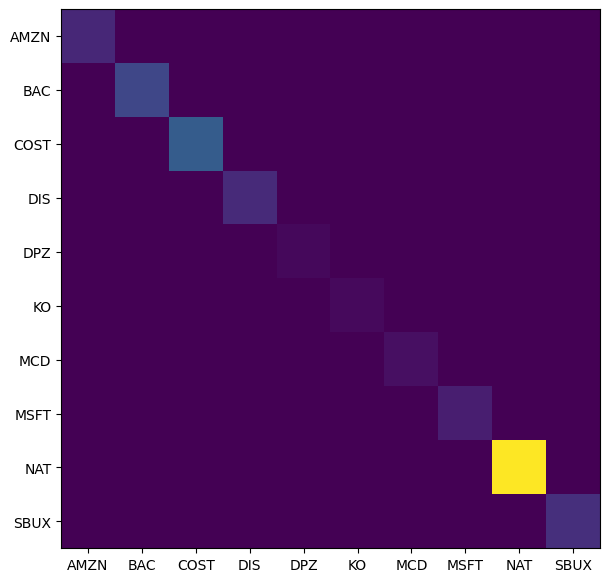

In [12]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [13]:
np.diag(bl.omega)

array([0.00457376, 0.00877523, 0.01203026, 0.00495928, 0.00088253,
       0.00112598, 0.00167908, 0.00345621, 0.04145162, 0.00552747])

In [14]:
#En vez de proveer la confianza nosotros, podemos calcular la matriz de incertidumbre al especificar un invervalo de confianza de 1SD 
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [15]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


# **Posterior estimates**

In [16]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [17]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pypfopt/black_litterman.py:400: RuntimeWarning: divide by zero encountered in matmul
  self._tau_sigma_P = self.tau * self.cov_matrix @ self.P.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pypfopt/black_litterman.py:400: RuntimeWarning: overflow encountered in matmul
  self._tau_sigma_P = self.tau * self.cov_matrix @ self.P.T
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pypfopt/black_litterman.py:400: RuntimeWarning: invalid value encountered in matmul
  self._tau_sigma_P = self.tau * self.cov_matrix @ self.P.T


Ticker
AMZN    0.173404
BAC     0.134757
COST    0.068338
DIS     0.073990
DPZ     0.107252
KO      0.008335
MCD     0.103356
MSFT    0.107044
NAT     0.063184
SBUX    0.086045
dtype: float64

In [18]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df


,Prior,Posterior,Views
AMZN,0.200629,0.173404,0.10
BAC,0.100786,0.134757,0.30
COST,0.076814,0.068338,0.05
DIS,0.090470,0.073990,0.05
DPZ,0.037719,0.107252,0.20
KO,0.051815,0.008335,-0.05
MCD,0.056674,0.103356,0.15
MSFT,0.155008,0.107044,0.10
NAT,0.040301,0.063184,0.50
SBUX,0.076181,0.086045,0.10


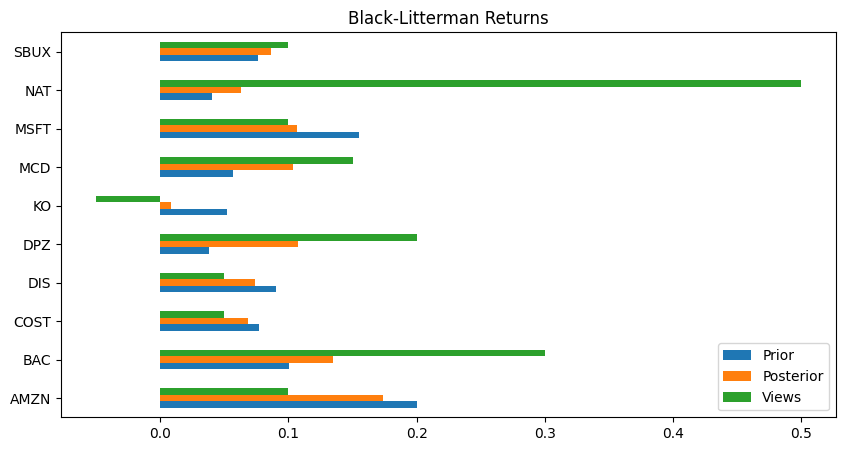

In [19]:
rets_df.plot.barh(figsize=(10,5), title="Black-Litterman Returns", legend=True);

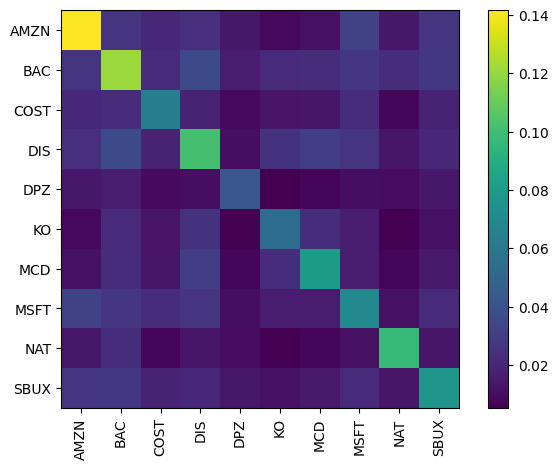

In [20]:
#Se puede usar un procedimiento similar para calcular la matriz de covarianza posterior
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

# Portfolio allocation

In [21]:
from pypfopt import EfficientFrontier, objective_functions

In [22]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AMZN', 0.19069),
             ('BAC', 0.14396),
             ('COST', 0.07214),
             ('DIS', 0.07107),
             ('DPZ', 0.12944),
             ('KO', 0.0),
             ('MCD', 0.11742),
             ('MSFT', 0.11764),
             ('NAT', 0.0669),
             ('SBUX', 0.09075)])

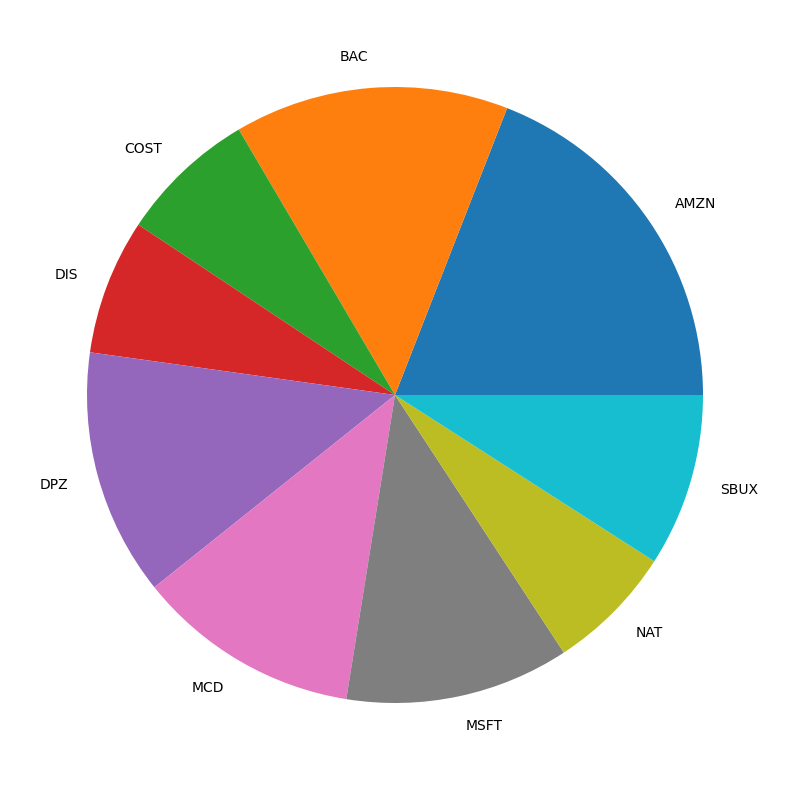

In [23]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [24]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $77.95


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/cvxpy/problems/problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


{'AMZN': 19,
 'BAC': 65,
 'COST': 1,
 'DIS': 13,
 'DPZ': 5,
 'KO': 1,
 'MCD': 8,
 'MSFT': 5,
 'NAT': 493,
 'SBUX': 22}